In [24]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from collections import namedtuple  
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import FeatureUnion


In [25]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.44169724,  0.        ])

In [26]:
class Gradient_Decent_with_eligibility:
    def __init__(self, dimension):
        self.w = np.random.randn(dimension)/np.sqrt(dimension)
        self.learning_rate = 1e-2
    
    def partial_fit(self, X, Y, eligibility_traces):
        self.w += self.learning_rate*(Y-X.dot(self.w))*eligibility_traces
        
    def predict(self, X):
        return X.dot(self.w)

In [27]:
class Model:
    def __init__(self, env, n_components=500):
        self.env = env
        self.standard = StandardScaler()
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        self.standard.fit(observation_examples)
        self.models = []
        self.featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
                ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
                ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
                ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
                ])
        print("why")
        self.standard.transform(observation_examples)
        example_features = self.featurizer.fit_transform(self.standard.transform(observation_examples))
        print("Wtf")
        self.eligibilities = np.zeros((env.action_space.n, example_features.shape[1]))
        for i in range(env.action_space.n):
            model = Gradient_Decent_with_eligibility(example_features.shape[1])
            self.models.append(model)
    
    def update(self, s, a, G, gamma, lamda):
        X = self.featurizer.transform(self.standard.transform([s]))
        self.eligibilities *= gamma*lamda
        self.eligibilities[a] += X[0]
        self.models[a].partial_fit(X[0], G, self.eligibilities[a])
    
    def predict(self, s):
        X = self.featurizer.transform(self.standard.transform([s]))
        return np.stack([m.predict(X) for m in self.models]).T
    
    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [28]:
def TD(model, env, eps, gamma=.9999, lamda=.7):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    while not done:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)
        guess = model.predict(observation)
        G = reward + gamma*np.max(guess[0])
        model.update(prev_observation, action, G, gamma, lamda)

        totalreward += reward
        iters += 1

    return totalreward

In [29]:
def plot_cost_to_go(env, estimator, num_tiles=20):
  x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
  y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
  X, Y = np.meshgrid(x, y)
  Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

  fig = plt.figure(figsize=(10, 5))
  ax = fig.add_subplot(111, projection='3d')
  surf = ax.plot_surface(X, Y, Z,
    rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
  ax.set_xlabel('Position')
  ax.set_ylabel('Velocity')
  ax.set_zlabel('Cost-To-Go == -V(s)')
  ax.set_title("Cost-To-Go Function")
  fig.colorbar(surf)
  plt.show()

why
Wtf


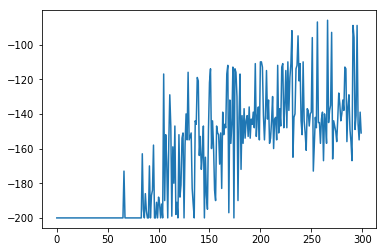

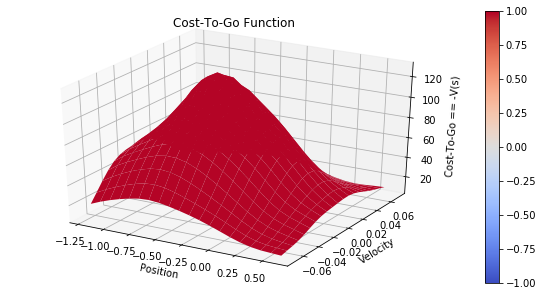

In [30]:
model =Model(env)

episodes = 300
rewards = []
for i in range(episodes):
    eps = 1*(0.99**i)
    reward=TD(env=env, model=model, eps=eps)
    rewards.append(reward)
plt.plot(rewards)
plt.show()
plot_cost_to_go(env, model)